# Пакеты

In [ ]:
!pip install pymorphy2
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 652.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=23ae1bb16b7354f660dccef12c8d34b15a8fcef556cf3fa03597ce10263ff587
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 968.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=1a96ab4d1b782bc9319608f4ee0f7767ca1cce2ba2b8d599b7bc2b20a4b9c870
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import pandas as pd
import seaborn as sns
import re
import requests
import warnings
from typing import Iterable, Callable
from matplotlib import pyplot as plt
from collections import Counter
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, accuracy_score
import numpy as np
import pymorphy2
from tqdm import tqdm
from functools import lru_cache
from IPython.core.display import HTML, display
from math import ceil
from gensim.models.doc2vec import Doc2Vec
import time
import umap
import torch


nltk.download('stopwords')
nltk.download('punkt')

warnings.simplefilter("ignore")
%matplotlib inline
sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Получение данных с кинопоиска

In [ ]:
headers = {"X-API-KEY": ""}

def get_movies_on_page(page: int, select_fields: list[str]) -> dict:
    response = requests.get(
        'https://api.kinopoisk.dev/v1.4/movie',
        params={
            "selectFields": select_fields,
            "limit": 250,
            "page": page,
        },
        headers=headers
    )
    return response.json()

In [ ]:
movie_select_fields = [
    "id",
    "name",
    "enName",
    "alternativeName",
    "description",
    "shortDescription",
    "slogan",
    "type",
    "year",
    "rating",
    "votes",
    "genres",
    "persons",
    "facts",
]

In [ ]:
def remove_href_pattern(s: str) -> str:
    return re.sub(r'<a\s+href="\/[^"]+"[^>]*>([^<]+)<\/a>', r'\1', s)

def remove_tabulate(df: pd.DataFrame, fields: list[str]) -> None:
    for field in fields:
        df[field] = df[field].apply(lambda text: str(text).replace("\n"," ").replace("\xa0", " ").replace("\r \r", ""))

def filter_movie_df(movie_df: pd.DataFrame) -> None:
    movie_df.facts = movie_df.facts.apply(lambda facts: [remove_href_pattern(fact['value']).replace("\n"," ").replace("\xa0", " ").replace("\r \r", "") for fact in facts] if facts is not None else None)
    movie_df.rating = movie_df.rating.apply(lambda rating: rating['imdb'])
    movie_df.votes = movie_df.votes.apply(lambda votes: votes['imdb'])
    movie_df.genres = movie_df.genres.apply(lambda genres: [genre['name'] for genre in genres] if genres is not None else None)
    remove_tabulate(movie_df, ("description","shortDescription", "slogan"))

In [ ]:
def create_movie_df_on_pages(pages: Iterable, select_fields: list[str]) -> pd.DataFrame:
    movie_df = pd.DataFrame()
    total_pages = max(pages)
    for page in pages:
        if page > total_pages:
            print("PAGES IS OVER!")
            return movie_df
        response = get_movies_on_page(page, select_fields)
        total_pages = response['pages']
        page_df = pd.DataFrame(response['docs'])
        filter_movie_df(page_df)
        movie_df = pd.concat([movie_df, page_df])
        movie_df = movie_df.reset_index(drop=True)
    return movie_df

In [ ]:
movie_df = create_movie_df_on_pages(range(1,11), movie_select_fields)

In [ ]:
movie_df

,rating,votes,id,type,name,description,slogan,year,facts,genres,persons,alternativeName,enName,shortDescription
0,8.5,906583,535341,movie,1+1,"Пострадав в результате несчастного случая, бог...",Sometimes you have to reach into someone else'...,2011,[На создание картины режиссёрский дуэт вдохнов...,"[драма, комедия, биография]","[{'id': 71427, 'photo': 'https://st.kp.yandex....",Intouchables,None,Аристократ на коляске нанимает в сиделки бывше...
1,7.8,375707,1143242,movie,Джентльмены,Один ушлый американец ещё со студенческих лет ...,Criminal. Class,2019,[Хью Грант и Чарли Ханнэм снимали свои сцены в...,"[криминал, комедия, боевик]","[{'id': 797, 'photo': 'https://st.kp.yandex.ne...",The Gentlemen,None,"Наркобарон хочет уйти на покой, но криминальны..."
2,8.2,1529079,462682,movie,Волк с Уолл-стрит,1987 год. Джордан Белфорт становится брокером ...,Earn. Spend. Party.,2013,[Фильм снят по мотивам книги мемуаров Джордана...,"[драма, криминал, биография, комедия]","[{'id': 37859, 'photo': 'https://st.kp.yandex....",The Wolf of Wall Street,None,Восхождение циника-гедониста на бизнес-олимп 1...
3,7.8,23670,41519,movie,Брат,"Демобилизовавшись, Данила Багров вернулся в ро...",None,1997,"[Свитер крупной вязки, который носил Данила Ба...","[драма, криминал, боевик]","[{'id': 25250, 'photo': 'https://st.kp.yandex....",None,None,Дембель Данила Багров защищает слабых в Петерб...
4,7.1,199196,1318972,movie,Гнев человеческий,Грузовики лос-анджелесской инкассаторской комп...,None,2021,[Хотя действие картины происходит в Лос-Анджел...,"[боевик, триллер]","[{'id': 1514, 'photo': 'https://st.kp.yandex.n...",Wrath of Man,None,"Хмурый мужчина прикидывается инкассатором, что..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,7.1,321756,898,movie,Бэтмен возвращается,Над Готэмом нависла новая угроза. Два эксцентр...,Возвращение 19 июня!,1992,[ДеВито было запрещено рассказывать о своем пе...,"[боевик, фантастика]","[{'id': 22773, 'photo': 'https://st.kp.yandex....",Batman Returns,Batman 2,Готэму угрожают человек-пингвин и Женщина-кошк...
2496,7.4,197471,7636,movie,Английский пациент,Вторая мировая война близится к концу. Молодая...,"In memory, love lives forever",1996,[Фильм снят по мотивам романа Майкла Ондаатже ...,"[драма, мелодрама, военный]","[{'id': 22670, 'photo': 'https://st.kp.yandex....",The English Patient,None,Война превращает роман картографа с чужой жено...
2497,7.1,144575,1211076,movie,Французский вестник. Приложение к газете «Либе...,"Собрание удивительных историй, опубликованных ...",None,2020,"[Имя и фамилия персонажа, которого исполнил Оу...","[драма, мелодрама, комедия]","[{'id': 518, 'photo': 'https://st.kp.yandex.ne...",The French Dispatch,None,После смерти главреда журналисты выпускают пос...
2498,6.2,139577,7316,movie,Джиперс Криперс,"Если бы Дэрри и Триш знали, во что превратится...",Кто тебя пожирает?,2001,[Рабочее название картины – «И тут приходит Бу...,"[ужасы, триллер]","[{'id': 1605, 'photo': 'https://st.kp.yandex.n...",Jeepers Creepers,Here Comes the Boogeyman,Жуткий незнакомец вторгается в жизнь брата и с...


In [ ]:
review_select_fields = [
    "id",
    "movieId",
    "title",
    "type",
    "review",
    "author",
    "authorId",
]

In [ ]:
def get_reviews_from_movie_ids_on_page(movie_ids: list[str], page: int, select_fields: list[str]) -> dict:
    response = requests.get(
        'https://api.kinopoisk.dev/v1.4/review',
        params={
            "selectFields": select_fields,
            "limit": 250,
            "movieId": movie_ids,
            "page": page,
        },
        headers=headers
    )
    return response.json()

In [ ]:
def filter_review_df(review_df: pd.DataFrame) -> None:
    remove_tabulate(review_df, ("review","title"))

In [ ]:
def create_review_df_from_limited_movie_ids(movie_ids: list[str], select_fields: list[str], page_limit: int = 5) -> pd.DataFrame:
    review_df = pd.DataFrame()
    total_pages = page_limit
    for page in range(1, page_limit+1):
        if page > total_pages:
            print("PAGES FOR MOVIE IDS IS OVER!")
            return review_df
        response = get_reviews_from_movie_ids_on_page(movie_ids, page, select_fields)
        total_pages = response['pages']
        page_df = pd.DataFrame(response['docs'])
        filter_review_df(page_df)
        review_df = pd.concat([review_df, page_df])
        review_df = review_df.reset_index(drop=True)
    print("EXCEEDED PAGE LIMIT FOR REVIEWS")
    return review_df

In [ ]:
def create_review_df_from_movie_ids(movie_ids: np.array, select_fields: list[str], page_limit: int = 5) -> pd.DataFrame:
    review_df = pd.DataFrame()
    size = movie_ids.shape[0]
    for it in range(ceil(size/250)):
        page_df = create_review_df_from_limited_movie_ids(movie_ids[it*250:min((it+1)*250,size)], review_select_fields)
        review_df = pd.concat([review_df, page_df]).reset_index(drop=True)
    return review_df

In [ ]:
review_df = create_review_df_from_movie_ids(movie_df.id.values, review_select_fields, page_limit = 10)

EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS
EXCEEDED PAGE LIMIT FOR REVIEWS


In [ ]:
review_df

,id,movieId,title,type,review,author,authorId
0,3324223,326,Главным героем всё это время был не Энди Дюфрейн,Позитивный,"Говоря про фильм «Побег из Шоушенка», то я все...",HochuHollywood,1453824.0
1,3323034,5019944,Даешь работу плутонянининанам! (хе-хе),Позитивный,Очень понравилась концовка. Очень не понравило...,bluebellaza,1084607.0
2,3322706,5019944,Новый взгляд на фантастику — Кибердеревня!,Позитивный,"Неожиданно классный сериал, сочетающий в себе ...",a.smirnova@creagames.ru,18658956.0
3,3322405,5019944,Растеряли все полимеры,Нейтральный,"Начался сериал бодренько, и серии до пятой я н...",mega-linch,31270117.0
4,3322252,5019944,Марсианский кукумбер увидел большой экран,Позитивный,"Думаю, многие видели короткие ролики, появивши...",barrels-n-bullets,21221018.0
...,...,...,...,...,...,...,...
12495,2958066,817509,реально крутой сериал,Позитивный,"На самом деле, редко советую кому нормальный с...",Александр Болсуновский - 1520,61330771.0
12496,2958038,412248,"Рецензия на фильм Все умрут, а я останусь",Позитивный,У всех разные ассоциации и воспоминания о школ...,danayassin,65077609.0
12497,2958010,1190387,Смерть во имя жизни.,Позитивный,"Очень странно, что рейтинг настолько низкий. М...",Очарованный_странник,14153751.0
12498,2957997,412248,"Осуждать нельзя, понять",Позитивный,"Кажется, что конфликт между родителями и детьм...",Anel Kemeshova,63175641.0


In [ ]:
len(list(set(pd.merge(review_df, movie_df, left_on='movieId', right_on='id', how='left')['name'].values)))

2112

In [ ]:
movie_df.to_csv("movies large.csv", index=False)

In [ ]:
review_df.to_csv("reviews large.csv", index=False)

# Получить датасет из kaggle

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"goshaserbin","key":""}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d goshaserbin/movies
!unzip movies

 94% 41.0M/43.8M [00:03<00:00, 14.9MB/s]
100% 43.8M/43.8M [00:03<00:00, 15.1MB/s]
Archive:  movies.zip
  inflating: movies large.csv        
  inflating: movies mini.csv         
  inflating: movies.csv              
  inflating: reviews large.csv       
  inflating: reviews mini.csv        
  inflating: reviews.csv             
  inflating: validation.csv          


In [ ]:
movie_df = pd.read_csv("movies large.csv")
review_df = pd.read_csv("reviews large.csv")

In [ ]:
val_df = pd.read_csv("validation.csv")
val_df['movieId'] = pd.merge(val_df, movie_df, left_on='movieName', right_on='name', how='left')['id']

# Анализ данных

In [ ]:
movie_df.name.unique()[600:700]

array(['Коралина в Стране Кошмаров', 'История игрушек: Большой побег',
       'Она', 'После', 'Мег: Монстр глубины', 'Призрак', 'Утиные истории',
       'Великолепный век', 'Уроки фарси', 'Отбросы', 'Маленькие женщины',
       'Голодные игры: Сойка-пересмешница. Часть I', 'Уикенд с батей',
       'Том и Джерри', 'Впритык', 'Матрица: Революция', 'Секс по дружбе',
       'Лжец, лжец', 'Самый пьяный округ в мире', 'Оффлайн', 'Пацаны',
       'Умница Уилл Хантинг', 'Заклятие', '28 дней спустя', 'Русалочка',
       'Экипаж', 'Бесконечность', 'Хищник', 'Зов предков',
       'Скотт Пилигрим против всех', 'Чудо-женщина', 'Анастасия',
       'Ветреная река', 'Храбрая сердцем', '1408', 'Бамблби',
       'Сумерки. Сага. Новолуние',
       'Шерлок Холмс и доктор Ватсон: Знакомство', 'Интервью с вампиром',
       'Морозко', 'Отличница лёгкого поведения', 'Белое солнце пустыни',
       'Мизантроп', 'Элизиум: Рай не на Земле', 'Летчик', 'Шазам!',
       'Знамение', 'Аферистка', 'Звездный путь', 'Мой 

In [ ]:
review_df

,id,movieId,title,type,review,author,authorId
0,3324223,326,Главным героем всё это время был не Энди Дюфрейн,Позитивный,"Говоря про фильм «Побег из Шоушенка», то я все...",HochuHollywood,1453824.0
1,3323034,5019944,Даешь работу плутонянининанам! (хе-хе),Позитивный,Очень понравилась концовка. Очень не понравило...,bluebellaza,1084607.0
2,3322706,5019944,Новый взгляд на фантастику — Кибердеревня!,Позитивный,"Неожиданно классный сериал, сочетающий в себе ...",a.smirnova@creagames.ru,18658956.0
3,3322405,5019944,Растеряли все полимеры,Нейтральный,"Начался сериал бодренько, и серии до пятой я н...",mega-linch,31270117.0
4,3322252,5019944,Марсианский кукумбер увидел большой экран,Позитивный,"Думаю, многие видели короткие ролики, появивши...",barrels-n-bullets,21221018.0
...,...,...,...,...,...,...,...
12495,2958066,817509,реально крутой сериал,Позитивный,"На самом деле, редко советую кому нормальный с...",Александр Болсуновский - 1520,61330771.0
12496,2958038,412248,"Рецензия на фильм Все умрут, а я останусь",Позитивный,У всех разные ассоциации и воспоминания о школ...,danayassin,65077609.0
12497,2958010,1190387,Смерть во имя жизни.,Позитивный,"Очень странно, что рейтинг настолько низкий. М...",Очарованный_странник,14153751.0
12498,2957997,412248,"Осуждать нельзя, понять",Позитивный,"Кажется, что конфликт между родителями и детьм...",Anel Kemeshova,63175641.0


In [ ]:
val_df

,review,movieName,movieId
0,Это аниме повествует об атаке гигантских челов...,Атака титанов,749374
1,В этом биографическом фильме рассказывается о ...,Богемская рапсодия,568289
2,"История про человека, который решил кардинальн...",Бойцовский клуб,361
3,Добрый мультик про робота-мусорщика и несерьез...,ВАЛЛ·И,279102
4,Фильм-биография про брокера. В фильме большое ...,Волк с Уолл-стрит,462682
5,Фильм по известной серии книг про особенного р...,Гарри Поттер и философский камень,689
6,"Старый фильм по книге Стивена Кинга, в котором...",Зеленая миля,435
7,В недалеком будущем наша планета стала практич...,Интерстеллар,258687
8,"Фильм по книге. Рассказана история детектива, ...",Остров проклятых,397667
9,Актер из человека паука в фильме про войну,По соображениям совести,649917


In [ ]:
index = 0
print(movie_df.name[index])
print(movie_df.description[index])
print(movie_df.shortDescription[index])

1+1
Пострадав в результате несчастного случая, богатый аристократ Филипп нанимает в помощники человека, который менее всего подходит для этой работы, – молодого жителя предместья Дрисса, только что освободившегося из тюрьмы. Несмотря на то, что Филипп прикован к инвалидному креслу, Дриссу удается привнести в размеренную жизнь аристократа дух приключений.
Аристократ на коляске нанимает в сиделки бывшего заключенного. Искрометная французская комедия с Омаром Си


In [ ]:
review_df[review_df.movieId == movie_df.id[index]].review.values[0]

'С уверенностью могу сказать, что это один из самых лучших фильмов современного кинематографа. Потрясающая история дружбы, которая проходит через время, боль, утрату, препятствия, но все равно сохраняет свою теплоту и доверие.  Клевый сюжет, который так или иначе затрагивает тему социального и финансового неравенства. Яркие актеры, лучезарный Идрис не оставляет равнодушным. Фильм ярко демонстрирует, что ни смотря ни на что, даже казалось бы непоправимые обстоятельства, наше счастье зависит от нас самих, а так же от тех людей, которых мы выбрали себе в окружение.  Обычный человек может быть спасательным кругом в той или иной жизненной ситуации. Важное иметь таких людей и платить верностью, заботой и любовью. Здорово, что фильм снят на основе реальных событий-это заставляет верить в добро и маленькое волшебство.  Элементы роскошной жизни (дорогие автомобили, частные самолёты, классические концерты музыки) так же цепляют. Но так же фильм отражает мысль, что не все купишь за деньги. И скол

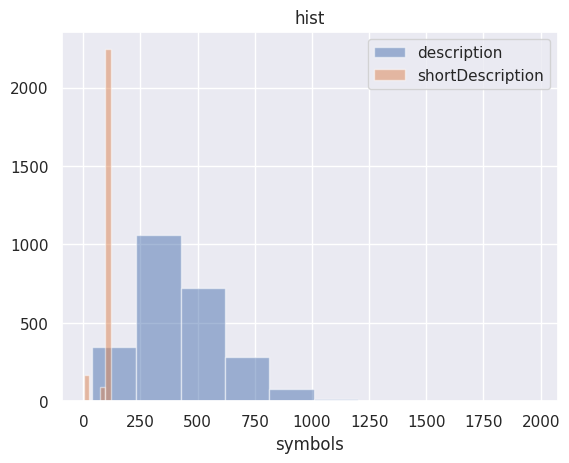

In [ ]:
plt.hist(movie_df.description.str.len(), alpha=0.5, label='description')
plt.hist(movie_df.shortDescription.str.len(), alpha=0.5, label='shortDescription', bins = 5)
plt.xlabel('symbols')
plt.title('hist')
plt.legend(loc='upper right')
plt.show()

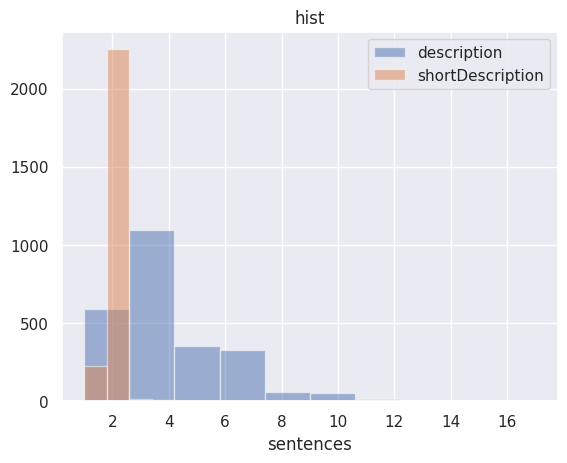

In [ ]:
movie_df.description.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='description')
movie_df.shortDescription.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='shortDescription', bins = 5)
plt.xlabel('sentences')
plt.title('hist')
plt.legend(loc='upper right')
plt.show()

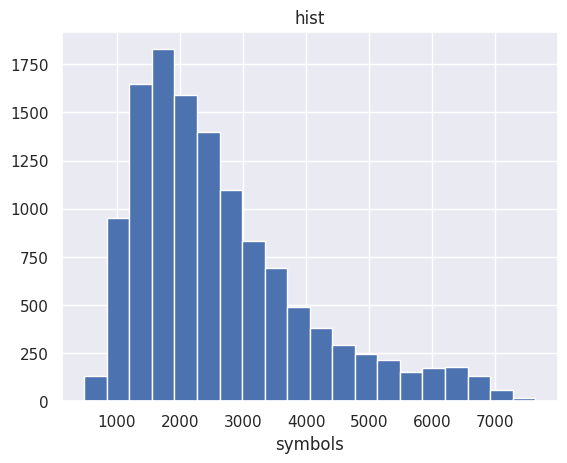

In [ ]:
review_df.review.str.len().hist(bins=20)
plt.xlabel('symbols')
plt.title('hist')
plt.show()

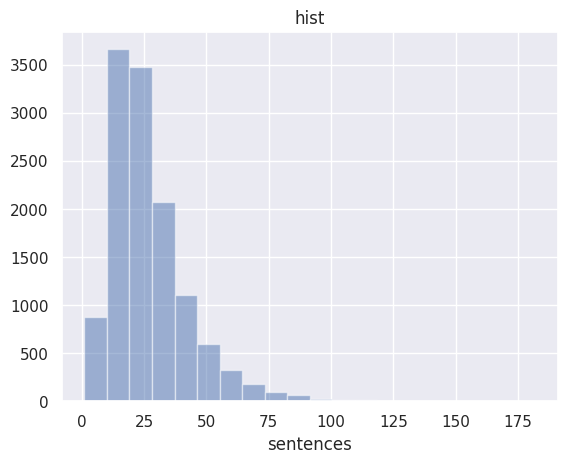

In [ ]:
review_df.review.apply(lambda text: len(str(text).rstrip(".").split("."))).hist(alpha=0.5, label='description',bins=20)
plt.xlabel('sentences')
plt.title('hist')
plt.show()

# Функции для работы с текстами

In [ ]:
STOP_WORDS = nltk.corpus.stopwords.words('russian') + ["фильм", "который"]
TOKEN_PATTERN: str = r"(?u)\b\w\w+\b"

In [ ]:
def tokenize(text: str, pattern: str) -> list[str]:
    return re.findall(pattern, text.lower())

lemmatizer = pymorphy2.MorphAnalyzer()
stemmer = nltk.stem.SnowballStemmer('russian')

@lru_cache(maxsize=None)
def cached_lemm(word: str) -> str:
    return lemmatizer.parse(word)[0].normal_form

def process_texts(texts: list[str], token_pattern: str, func: Callable[[str],str], with_stop_words = False, with_concat = True) -> list[str]:
    tokenized_texts = [tokenize(text, token_pattern) for text in texts]
    processed_texts = []
    for text in tqdm(tokenized_texts):
        processed_text = [func(word) for word in text if (not with_stop_words) or (word not in STOP_WORDS)]
        if with_stop_words:
            processed_text = [word for word in text if word not in STOP_WORDS]
        if with_concat:
            processed_text = " ".join(processed_text)
        processed_texts.append(processed_text)
    return processed_texts

def lemmatize(texts: list[str], token_pattern: str = TOKEN_PATTERN, with_stop_words = False, with_concat = True) -> list[str]:
    return process_texts(texts, token_pattern, cached_lemm, with_stop_words, with_concat)

def stem(texts: list[str], token_pattern: str = TOKEN_PATTERN, with_stop_words = False, with_concat = True) -> list[str]:
    return process_texts(texts, token_pattern, stemmer.stem, with_stop_words, with_concat)



In [ ]:
lemmatize(['сегодня хорошая погода у меня'], token_pattern = TOKEN_PATTERN, with_stop_words=True, with_concat=False)

100%|██████████| 1/1 [00:00<00:00, 980.21it/s]


[['сегодня', 'хорошая', 'погода']]

# Модели

## TFIDF

In [ ]:
class TfidfModel:
    def __init__(
        self,
        with_lemmatizing: bool = True,
        with_stemming: bool = False,
        token_pattern: str = r"(?u)\b\w\w+\b",
        *args,
        **kwargs,
        ):

        self.token_pattern = token_pattern
        self.with_lemmatizing = with_lemmatizing
        self.with_stemming = with_stemming
        self.vectorizer = TfidfVectorizer(token_pattern=token_pattern, *args, **kwargs)
        self.tfidf_embds = None

    def process_texts(self, texts: list[str]) -> list[str]:
        if self.with_lemmatizing:
            texts = lemmatize(texts, self.token_pattern)
        elif self.with_stemming:
            texts = stem(texts, self.token_pattern)
        return texts

    def fit(self, texts: list[str]):
        texts = self.process_texts(texts)
        self.tfidf_embds = self.vectorizer.fit_transform(texts)

    def vectorize(self, texts: list[str]) -> np.array:
        texts = self.process_texts(texts)
        return self.vectorizer.transform(np.array(texts))

    def predict(self, texts: list[str]) -> list[int]:
        x = self.vectorize(texts)
        cos_sims = np.dot(x, self.tfidf_embds.T).toarray() # x_x
        indexes = np.argmax(cos_sims, axis = 1)
        return indexes

In [ ]:
model = TfidfModel(stop_words = stop_words, ngram_range=(1, 2), max_df = 0.9)

### Описания будут сравниваться с описаниями на кинопоиске

In [ ]:
train_texts = movie_df.description.values
model.fit(train_texts)

100%|██████████| 1500/1500 [00:03<00:00, 444.25it/s]


Проверка на коротких описаниях с кинопоиска

In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred = movie_df.id[model.predict(test_texts)].values
accuracy_score(y_true, y_pred)

100%|██████████| 1500/1500 [00:00<00:00, 3071.42it/s]


0.328

Проверка на собственном датасете

In [ ]:
val_texts = val_df.review.values
y_pred = movie_df.id[model.predict(val_texts)].values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

In [ ]:
def validate(y_pred: list[int], y_true: list[int], val_texts: list[str]):
    token2id = {token: i for i, token in enumerate(sorted(model.vectorizer.vocabulary_))}
    chosen = pd.merge(pd.Series(y_pred).rename('ids'), movie_df, left_on= 'ids', right_on='id', how='left')[['name', 'description']]
    chosen_names = chosen.name.values
    chosen_embds = model.vectorize(chosen.description.values)

    true_names = pd.merge(pd.Series(y_true).rename('ids'), movie_df, left_on= 'ids', right_on='id', how='left')['name'].values

    importance = model.vectorize(val_texts).multiply(chosen_embds)
    max_importance = importance.max()
    texts_tokens = model.join_tokenize(val_texts)

    for i, text in enumerate(val_texts):
        print("\n\n\n")
        print(f'predicted = {chosen_names[i]}')
        print(f'true = {true_names[i]}')

        text_tokens = texts_tokens[i].split()

        html_string = '''
        <p style="font-size:16px; color:#000000; border: 2px solid #000; text-align: justify; background-color:#ffffff; border-radius: 25px; padding: 20px;">
        '''

        for token in text_tokens:
            if token in token2id:
                weight = importance[i,token2id[token]]
                component = hex(int(255 - 255 * weight / max_importance))[2:]
                color = f'{component}{component}ff'
            else:
                weight = 0.0
                color = 'ffffff'
            html_string += f'<span style="background-color: #{color}"; title="{weight:.2f}">{token}</span> '

        html_string += '</p>'

        display(HTML(html_string))


In [ ]:
validate(y_pred, y_true, val_texts)

100%|██████████| 19/19 [00:00<00:00, 8534.14it/s]





predicted = Человек-паук: Через вселенные
true = Атака титанов






predicted = Эдвард руки-ножницы
true = Богемская рапсодия






predicted = Физрук
true = Бойцовский клуб






predicted = Я, робот
true = ВАЛЛ·И






predicted = Последний рубеж
true = Волк с Уолл-стрит






predicted = Библиотекарь
true = Гарри Поттер и философский камень






predicted = Библиотекарь
true = Зеленая миля






predicted = Чёрная дыра
true = Интерстеллар






predicted = Заклятие
true = Остров проклятых






predicted = Человек-паук: Через вселенные
true = По соображениям совести






predicted = Человек-паук: Через вселенные
true = По соображениям совести






predicted = Любовь. Смерть. Роботы
true = Рататуй






predicted = Леди Баг и Супер-кот
true = Титаник






predicted = Шрэк
true = Шрэк






predicted = Красавица и чудовище
true = Оно






predicted = Ледниковый период
true = Властелин колец: Братство Кольца






predicted = Я, робот
true = ВАЛЛ·И






predicted = Мажор
true = Один дома






predicted = Гром: Трудное детство
true = Шрэк


### Описания будут сравниваться с отзывами (цельными)

In [ ]:
train_texts = review_df.review.values
model.fit(train_texts)

100%|██████████| 7500/7500 [00:30<00:00, 243.36it/s]


Проверка на коротких описаниях с кинопоиска

In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred= review_df.movieId[model.predict(test_texts)].values
accuracy_score(y_true, y_pred)

100%|██████████| 1500/1500 [00:00<00:00, 88831.01it/s]


0.3473333333333333

Проверка на собственном датасете

In [ ]:
val_texts = val_df.review.values
y_pred = review_df.movieId[model.predict(val_texts)].values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

100%|██████████| 19/19 [00:00<00:00, 39885.77it/s]


0.21052631578947367

In [ ]:
validate(y_pred, y_true, val_texts)

100%|██████████| 19/19 [00:00<00:00, 18290.52it/s]





predicted = Твоё имя
true = Атака титанов






predicted = Король и Шут
true = Богемская рапсодия






predicted = Мы купили зоопарк
true = Бойцовский клуб






predicted = ВАЛЛ·И
true = ВАЛЛ·И






predicted = Не смотрите наверх
true = Волк с Уолл-стрит






predicted = Орудия смерти: Город костей
true = Гарри Поттер и философский камень






predicted = Зеленая миля
true = Зеленая миля






predicted = Кин-дза-дза!
true = Интерстеллар






predicted = Остров проклятых
true = Остров проклятых






predicted = Новый Человек-паук
true = По соображениям совести






predicted = Новый Человек-паук
true = По соображениям совести






predicted = Рататуй
true = Рататуй






predicted = Русалочка
true = Титаник






predicted = Шрэк навсегда
true = Шрэк






predicted = Мгла
true = Оно






predicted = Король и Шут
true = Властелин колец: Братство Кольца






predicted = Живая сталь
true = ВАЛЛ·И






predicted = Однажды в Вегасе
true = Один дома






predicted = Мизантроп
true = Шрэк


### Описания будут сравниваться с отзывами (все предложения из отзывов отдельно)

In [ ]:
model = TfidfModel(stop_words = stop_words, ngram_range=(1, 2), max_df = 0.5)

In [ ]:
# разделить отзывы на предложения
sentences = []
for review in review_df['review']:
    for sent in nltk.sent_tokenize(review):
        sentences.append(sent)

# создать новый датафрейм
review_sent_df = pd.DataFrame({'sentences': sentences, 'movieId': review_df['movieId'].repeat(review_df['review'].apply(nltk.sent_tokenize).apply(len))}).reset_index(drop=True)

In [ ]:
review_sent_df

,sentences,movieId
0,"Говоря про фильм «Побег из Шоушенка», то я все...",326
1,"Это точно история Реддинга, а не Энди Дюфрейна...",326
2,"Он действительно предстает перед нами, как зре...",326
3,"Это точно история Эллиса Бойда Реддинга, тем б...",326
4,Очень понравилась концовка.,5019944
...,...,...
337811,"Но далеко не всегда фильм объясняет, почему им...",933208
337812,"В «Коме» такой, казалось бы, незначительной де...",933208
337813,"Именно эта деталь, думаю, и является ядром фил...",933208
337814,Именно эта деталь придаёт открытой концовке ос...,933208


In [ ]:
train_texts = review_sent_df.sentences.values
model.fit(train_texts)

100%|██████████| 204296/204296 [00:01<00:00, 106227.55it/s]


Проверка на коротких описаниях с кинопоиска

In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred= review_sent_df.movieId[model.predict(test_texts)].values
accuracy_score(y_true, y_pred)

100%|██████████| 1500/1500 [00:00<00:00, 116926.35it/s]


0.14666666666666667

Проверка на собственном датасете

In [ ]:
val_texts = val_df.review.values
y_pred = review_sent_df.movieId[model.predict(val_texts)].values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

100%|██████████| 19/19 [00:00<00:00, 7163.31it/s]


0.10526315789473684

In [ ]:
validate(y_pred, y_true, val_texts)

100%|██████████| 19/19 [00:00<00:00, 13416.12it/s]





predicted = Адвокат дьявола
true = Атака титанов






predicted = Постучись в мою дверь
true = Богемская рапсодия






predicted = Груз 200
true = Бойцовский клуб






predicted = ВАЛЛ·И
true = ВАЛЛ·И






predicted = Красное уведомление
true = Волк с Уолл-стрит






predicted = Форсаж 9
true = Гарри Поттер и философский камень






predicted = Охотники за разумом
true = Зеленая миля






predicted = Первому игроку приготовиться
true = Интерстеллар






predicted = Шерлок
true = Остров проклятых






predicted = Человек-паук: Возвращение домой
true = По соображениям совести






predicted = Человек-паук: Возвращение домой
true = По соображениям совести






predicted = Матрица: Воскрешение
true = Рататуй






predicted = После
true = Титаник






predicted = Шрэк
true = Шрэк






predicted = Матрица: Воскрешение
true = Оно






predicted = Кибердеревня
true = Властелин колец: Братство Кольца






predicted = Не смотрите наверх
true = ВАЛЛ·И






predicted = Белый лотос
true = Один дома






predicted = Век Адалин
true = Шрэк


### Описания будут сравниваться с отзывами (все отзвы по одному фильму группируются в один большой)

In [ ]:
grouped_reviews_df = review_df.groupby('movieId')['review'].apply(lambda x: '. '.join(x))
grouped_reviews_df = pd.DataFrame({'review': grouped_reviews_df, 'movieId': grouped_reviews_df.index}).reset_index(drop=True)
grouped_reviews_df

,review,movieId
0,О чём фильм? Мутант совершает покушение на Пре...,298
1,Для миллионов режиссеров секрет достойного сик...,299
2,"Матрица - это кино, которое в свое время измен...",301
3,Вы никогда не задумывались почему люди лгут? К...,305
4,Тема фильма очень знакома. Система мира больше...,309
...,...,...
1304,"Завязка была довольно многообещающая, я ожидал...",5189350
1305,"22:14 Если коротко, то сюжет вторичен, графика...",5194326
1306,Вторая часть получается даже смешнее и мелодра...,5236765
1307,Канал СТС в последнее время выдает очень уж ус...,5249042


In [ ]:
model = TfidfModel(stop_words = stop_words, ngram_range=(1, 2), max_df = 0.9)
train_texts = grouped_reviews_df.review.values
model.fit(train_texts)

100%|██████████| 1309/1309 [00:01<00:00, 757.64it/s]


Проверка на коротких описаниях с кинопоиска

In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred= grouped_reviews_df.movieId[model.predict(test_texts)].values
accuracy_score(y_true, y_pred)

100%|██████████| 1500/1500 [00:00<00:00, 79657.84it/s]


0.37066666666666664

Проверка на собственном датасете

In [ ]:
val_texts = val_df.review.values
y_pred = grouped_reviews_df.movieId[model.predict(val_texts)].values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

100%|██████████| 19/19 [00:00<00:00, 41592.78it/s]


0.21052631578947367

In [ ]:
validate(y_pred, y_true, val_texts)

100%|██████████| 19/19 [00:00<00:00, 16167.94it/s]





predicted = Атака титанов
true = Атака титанов






predicted = Жизнь прекрасна
true = Богемская рапсодия






predicted = Мы купили зоопарк
true = Бойцовский клуб






predicted = ВАЛЛ·И
true = ВАЛЛ·И






predicted = Не смотрите наверх
true = Волк с Уолл-стрит






predicted = Библиотекарь
true = Гарри Поттер и философский камень






predicted = Зеленая миля
true = Зеленая миля






predicted = Планета обезьян: Война
true = Интерстеллар






predicted = Пляж
true = Остров проклятых






predicted = Человек-паук: Нет пути домой
true = По соображениям совести






predicted = Человек-паук: Нет пути домой
true = По соображениям совести






predicted = Рататуй
true = Рататуй






predicted = Прометей
true = Титаник






predicted = Шрэк навсегда
true = Шрэк






predicted = Мгла
true = Оно






predicted = Король и Шут
true = Властелин колец: Братство Кольца






predicted = Двухсотлетний человек
true = ВАЛЛ·И






predicted = Не пойман — не вор
true = Один дома






predicted = Мизантроп
true = Шрэк


### **Конспект по модели.**
+: Просто, понятно, интерпретируемо

-: Не масштабируемо, слишком наивно, плохой скор, не улавливает семантику

## Doc2Vec

In [ ]:
class Doc2VecModel:
    def __init__(
        self,
        with_lemmatizing: bool = True,
        with_stemming: bool = False,
        token_pattern: str = r"(?u)\b\w\w+\b",
        ):

        self.token_pattern = token_pattern
        self.with_lemmatizing = with_lemmatizing
        self.with_stemming = with_stemming
        self.file_name = "doc2vec_texts_corpus.txt"

    def process_texts(self, texts: list[str]) -> list[str]:
        if self.with_lemmatizing:
            texts = lemmatize(texts, self.token_pattern, with_stop_words=True)
        elif self.with_stemming:
            texts = stem(texts, self.token_pattern, with_stop_words=True)
        return texts


    def fit(self, texts: list[str], *args, **kwargs):
        texts = self.process_texts(texts)
        with open(self.file_name, "w", encoding="UTF-8", buffering=1) as file:
            for text in texts:
                file.write(text + "\n")
        self.model = Doc2Vec(corpus_file = self.file_name, *args, **kwargs)

    def vectorize(self, texts: list[str]) -> list[np.array]:
        texts = self.process_texts(texts)
        return [self.model.infer_vector(text.split()) for text in texts]

    def predict(self, texts: list[str]) -> list[int]:
        vectors = self.vectorize(texts)
        indexes = [np.argmin(self.model.dv.distances(vector)) for vector in vectors]
        return indexes

    def most_similar(self, text: str, k: int = 10) -> list:
        vector = self.vectorize([text])[0]
        distances = self.model.dv.distances(vector)
        top = torch.topk(torch.Tensor(distances), k)
        return top


### Подбор гиперпараметров

In [ ]:
params = {
    "vector_size" : [128], #[2 ** i for i in range(6,11)],
    "epochs" :  [2400],#[1800,2100,2400],
    "window" : [4], #list(range(2,8)),
    "shrink_windows" : [1],
    "alpha" :  [0.025],#np.linspace(0.02,0.03,1000), #[0.01, 0.075, 0.005, 0.0025, 0.001]
}

test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values

max_score = 0

for iter in range(200):
    time_start = time.time()
    print(f"{iter=}")
    cur_params = {arg_name : np.random.choice(arg_vals) for arg_name,arg_vals in params.items()}
    model.fit(movie_df.description.values, dm=0, **cur_params)
    y_pred = movie_df.iloc[model.predict(test_texts)].id.values
    cur_score = accuracy_score(y_true, y_pred)
    if cur_score > max_score:
        max_score = cur_score
        print(f"!!!      NEW MAX_SCORE {max_score} achived with {cur_params}")
    else:
        print(f"score {cur_score} achived with {cur_params}")
    print("time of exec:", time.time() - time_start, "sec\n\n")

new max_score 0.16 achived with {'vector_size': 256, 'epochs': 1500, 'window': 6, 'dm': 0, 'shrink_windows': 0, 'alpha': 0.005}

NEW MAX_SCORE 0.164 achived with {'vector_size': 128, 'epochs': 2000, 'window': 4, 'dm': 0, 'shrink_windows': 1, 'alpha': 0.0025}

time of exec: 48.1322968006134 sec

In [ ]:
params = {'vector_size': 128, 'epochs': 2000, 'window': 4, 'dm': 0, 'shrink_windows': 1, 'alpha': 0.0025}
model = Doc2VecModel()
model.fit(movie_df.description.values,**params)

100%|██████████| 250/250 [00:01<00:00, 200.48it/s]


In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred = movie_df.iloc[model.predict(test_texts)].id.values
accuracy_score(y_true, y_pred)

100%|██████████| 250/250 [00:00<00:00, 443.78it/s]


0.164

In [ ]:
val_texts = val_df.review.values
y_pred = movie_df.iloc[model.predict(val_texts)].id.values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

100%|██████████| 19/19 [00:00<00:00, 10176.45it/s]


0.0

### Группируем обзоры

In [ ]:
grouped_reviews_df = review_df.groupby('movieId')['review'].apply(lambda x: '. '.join(x))
grouped_reviews_df = pd.DataFrame({'review': grouped_reviews_df, 'movieId': grouped_reviews_df.index}).reset_index(drop=True)
grouped_reviews_df

,review,movieId
0,О чём фильм? Мутант совершает покушение на Пре...,298
1,Для миллионов режиссеров секрет достойного сик...,299
2,"Матрица - это кино, которое в свое время измен...",301
3,Дэйв Базник парень еврейской наружности из Бру...,303
4,Вы никогда не задумывались почему люди лгут? К...,305
...,...,...
2147,"Я не смотрел оригинальный мультсериал, поэтому...",5249392
2148,Среди молодежи в свое время был популярен сери...,5292981
2149,Жоре Крыжовникову удалось создать самый настоя...,5304403
2150,Сериал «Крутая перемена» рассказывает нам о гл...,5313200


In [ ]:
params = {'vector_size': 128, 'epochs': 120, 'window': 4, 'dm': 0, 'shrink_windows': 1, 'dm_mean':1, 'ns_exponent':0.0,'min_count': 2}
model = Doc2VecModel()
model.fit(grouped_reviews_df.review.values, **params)

100%|██████████| 2152/2152 [00:56<00:00, 38.14it/s]


In [ ]:
test_texts = movie_df.shortDescription.values
y_true = movie_df.id.values
y_pred= grouped_reviews_df.movieId[model.predict(test_texts)].values
accuracy_score(y_true, y_pred)

100%|██████████| 2500/2500 [00:00<00:00, 28740.08it/s]


0.338

In [ ]:
val_texts = val_df.review.values
y_pred= grouped_reviews_df.movieId[model.predict(val_texts)].values
y_true = val_df.movieId.values
accuracy_score(y_true, y_pred)

100%|██████████| 38/38 [00:00<00:00, 4713.68it/s]


0.05263157894736842

In [ ]:
movie_vectors = model.vectorize(movie_df.description.values)

100%|██████████| 2500/2500 [00:01<00:00, 1971.53it/s]


In [ ]:
short_descr_vectors =  model.vectorize(movie_df.shortDescription.values)

100%|██████████| 2500/2500 [00:00<00:00, 30519.39it/s]


In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
dists = distance_matrix(np.stack(short_descr_vectors), np.stack(movie_vectors))

In [ ]:
answers = np.argmin(dists,axis = 1)

In [ ]:
len([0 for i, el in enumerate(answers) if el == i ])

76

In [ ]:
indices = model.most_similar(movie_df.shortDescription.values[215], k = 20).indices

100%|██████████| 1/1 [00:00<00:00, 753.29it/s]


In [ ]:
movie_df.iloc[210]

rating                                                            7.8
votes                                                          561472
id                                                               5502
type                                                            movie
name                                                Назад в будущее 2
description         Продолжение фантастической истории о приключен...
slogan                                              Все это о времени
year                                                             1989
facts               ['Во время съемок &#171;будущего&#187; Майкл Д...
genres              ['фантастика', 'приключения', 'боевик', 'комед...
persons             [{'id': 181, 'photo': 'https://st.kp.yandex.ne...
alternativeName                            Back to the Future Part II
enName                                      Back to the Future Part 2
shortDescription    Док и Марти решили исправить будущее, но сперв...
Name: 210, dtype: ob

In [ ]:
pd.merge(grouped_reviews_df.movieId[indices.numpy()],movie_df,left_on='movieId', right_on='id', how='left').name

0     Доктор Стрэндж: В мультивселенной безумия
1                                   Темные воды
2                                          Жуки
3                                          Мира
4                                       Призрак
5                        Вампиры средней полосы
6                               Марафон желаний
7                        Любовь. Смерть. Роботы
8                             Серебряные коньки
9                           Свадьба в Малиновке
10             Звёздные войны: Последние джедаи
11                                 Купе номер 6
12                                    Водоворот
13                   Артек. Большое путешествие
14               Чук и Гек. Большое приключение
15                                 Спортлото-82
16                                  Ширли-мырли
17                                         Локи
18             Звёздные войны: Пробуждение силы
19                                     Нежность
Name: name, dtype: object

## Визуализация с уменьшением размерности

In [ ]:
import plotly

In [ ]:
def plot_tsne_embeddings(embeddings: np.ndarray, annotations: np.ndarray) -> None:
    trace = plotly.graph_objs.Scattergl(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        name="Embedding",
        mode="markers",
        marker={"colorscale": "Viridis", "size": 6, "line": {"width": 0.5}, "opacity": 0.75},
        text=annotations,
    )

    layout = {
        "title": "Some Title =)",
        "yaxis": {"zeroline": False},
        "xaxis": {"zeroline": False},
        "hovermode": "closest",
        "width": 800,
        "height": 800,
    }

    display(plotly.graph_objs.Figure(data=[trace], layout=layout))

In [ ]:
embeddings = np.stack(model.vectorize(review_df.review.values))
annotations = pd.merge(review_df.movieId, movie_df, left_on='movieId', right_on='id', how='left')['name'].values
plot_tsne_embeddings(embeddings, annotations)

100%|██████████| 1250/1250 [00:00<00:00, 6963.01it/s]


In [ ]:
import umap
manifold = umap.UMAP().fit(embeddings, review_df.movieId.values)
X_reduced = manifold.transform(embeddings)

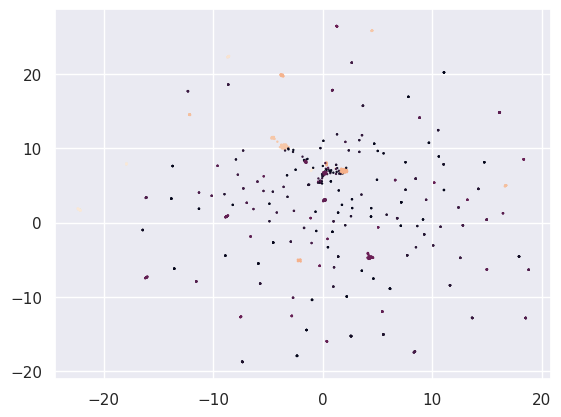

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=review_df.movieId.values, s=0.5);

In [ ]:
plot_tsne_embeddings(X_reduced, annotations)

## Word2Vec

In [ ]:
import gensim
from gensim.models import Word2Vec,KeyedVectors


processed_texts = lemmatize(review_df.review.values, with_stop_words=True,with_concat=False)

100%|██████████| 12500/12500 [01:41<00:00, 123.66it/s]


In [ ]:
vector_size = 512
word2vec = gensim.models.Word2Vec(
    processed_texts,
    vector_size=vector_size, epochs = 1
)

In [ ]:
word2vec.wv.most_similar('женщина')

[('девочка', 0.5959749221801758),
 ('девушка', 0.5782814621925354),
 ('независимая', 0.5432456731796265),
 ('девчонка', 0.5354838371276855),
 ('бесстрашная', 0.5080028772354126),
 ('умная', 0.4997139573097229),
 ('взбалмошная', 0.4942726790904999),
 ('особа', 0.4908306300640106),
 ('барышня', 0.4907078742980957),
 ('воспитанная', 0.4879399836063385)]

In [ ]:
# import gensim.downloader
# pretraind_w2v = gensim.downloader.load('word2vec-ruscorpora-300')
# pretraind_w2v.most_similar('женщина_NOUN')

## RNN

In [ ]:
from torch import nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)

        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.out_size = out_size
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # x: (n, 28, 28), h0: (2, n, 128)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        # or:
        #out, _ = self.lstm(x, (h0,c0))

        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)

        out = self.fc(out)
        # out: (n, 10)
        return out

### Учим предложение

In [ ]:
model = RNN(input_size = 128, hidden_size = 128, num_layers = 1, out_size = 128).to(device)

In [ ]:
sentence = 'женщина гуляла по мосту'
tokens = lemmatize([sentence], token_pattern = TOKEN_PATTERN, with_stop_words=True, with_concat=False)[0]
vectors = [torch.tensor(word2vec.wv.get_vector(word)) for word in tokens if word2vec.wv.has_index_for(word) ]
vectors = torch.stack(vectors).to(device)

model = RNN(input_size = 128, hidden_size = 128, num_layers = 1, out_size = 128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
vectors.unsqueeze_(0)
answer = model(vectors)[0].detach()
word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(answer))]

100%|██████████| 1/1 [00:00<00:00, 5841.65it/s]


'постельные'

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from torch import nn

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # вычисляем расстояния между anchor и positive
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        # вычисляем расстояния между anchor и negative
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
        # вычисляем разницу между расстояниями и добавляем margin
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0)
        # усредняем по батчу
        loss = torch.mean(loss)
        return loss

In [ ]:
criterion = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return self.df.size

    def __getitem__(self, idx):
        item = review_sent_df.iloc[0]

        return item.sentences, item.movieId

dataset = MovieDataset(review_sent_df)

In [ ]:
import random

def collate_fn(batch):
    batch_size = len(batch)
    new_imgs = torch.zeros(3*batch_size, *batch[0]['image'].shape)
    new_labels = torch.zeros(3*batch_size, *batch[0]['label'].shape)
    for i in range(batch_size):
        #anchor
        label = batch[i]['label'].item()
        new_imgs[3*i,...] = batch[i]['image']
        new_labels[3*i,...] = batch[i]['label']

        #positive
        positive_indicies = class_indicies[label]
        choice = random.choice(positive_indicies)
        new_imgs[1+3*i,...] = train_dataset[choice]['image']
        new_labels[1+3*i,...] = torch.tensor([choice])

        #negative
        negative_indicies = class_indicies[:label] + class_indicies[label+1:]
        choice = random.choice(random.choice(negative_indicies))
        new_imgs[2+3*i,...] = train_dataset[choice]['image']
        new_labels[2+3*i,...] = torch.tensor([choice])

    return { "image" : new_imgs.to(device), "label" : new_labels.to(device)}

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

In [ ]:
num_epochs = 1
model.train()
for epoch in range(num_epochs):
    for sentences, movieIds in train_dataloader:
        tokens = lemmatize(sentences, token_pattern = TOKEN_PATTERN, with_stop_words=True, with_concat=False)
        vectors = torch.stack([torch.stack([torch.tensor(word2vec.wv.get_vector(word)) for word in sentence if word2vec.wv.has_index_for(word)]) for sentence in sentences]).to(device)

        # разделение на anchor, positive и negative
        anchor = embeddings[::3]
        positive = embeddings[1::3]
        negative = embeddings[2::3]
        # вычисление loss и обновление параметров
        loss = criterion(anchor, positive, negative)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())

    print('Epoch: {}, Loss: {}'.format(epoch+1, loss.item()))

In [ ]:
!pip install code-tokenize

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00
  Created wheel for code-tokenize: filename=code_tokenize-0.2.0-py3-none-any.whl size=13863 sha256=31d61cd181a0d75fa45deea714e3f1f191d7d8b29af3873f5b85ed09cc6a8b84
  Stored in directory: /root/.cache/pip/wheels/8b/20/d2/c85b7294f3aa192ade2924a7e2c94c6b0f45c806c181644b64
  Created wheel for code-ast: filename=code_ast-0.1.0-py3-none-any.whl size=11827 sha256=fe8f4e7557ecf0f2dca5caf47763145672f5221c4c988cd88c1d1a1385226534
  Stored in directory: /root/.cache/pip/wheels/39/6c/09/e08b77926bdbe612cc11e7d460f2d35aa646d5fbdf94f85933
Successfully built code-tokenize code-ast


In [ ]:
text = """
#include "Application.hpp"
#include "ICalculator.hpp"

#include <iostream>

namespace Nummy {

    auto Application::run(int argc, char** argv, std::ostream& out = std::cout) -> void {
        auto calculator = m_calculatorInitializer.makeCalculator(argc, argv, out);
        if (calculator) {
            calculator->run();
        }
    }

}  // namespace Nummy
"""

import code_tokenize as ctok

# Python
tokens = ctok.tokenize(
    text,
lang = "cpp")

In [ ]:
print("".join([str(token) for token in tokens]))

#include"Application.hpp"#include"ICalculator.hpp"#include<iostream>namespaceNummy{autoApplication::run(intargc,char**argv,std::ostream&out=std::cout)->void{autocalculator=m_calculatorInitializer.makeCalculator(argc,argv,out);if(calculator){calculator->run();}}}// namespace Nummy


In [ ]:
tokens = tokenize(text, pattern = r"\s*([A-Za-z_]\w*)\s*|(::)|([<>{}\[\];(),./*%+-])|\n")
tokens = [max(token) for token in tokens]
tokens = [token if token!="" else "\n" for token in tokens]
s = "".join(tokens)
print(s)


includeapplication.hpp
includeicalculator.hpp

include<iostream>namespacenummy{autoapplication::run(intargc,char**argv,std::ostreamoutstd::cout)->void{autocalculatorm_calculatorinitializer.makecalculator(argc,argv,out);if(calculator){calculator->run();
}
}

}//namespacenummy


In [ ]:
tokenize("hello world", pattern = TOKEN_PATTERN)

['hello', 'world']